In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load data
train_df = pd.read_csv("https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv", sep="\t", header=0)
train_df.columns = ['sentence', 'label']
test_df = pd.read_csv("https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv", sep="\t", header=0)
test_df.columns = ['sentence', 'label']


# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_full = vectorizer.fit_transform(train_df['sentence']).toarray()
y_train_full = train_df['label'].values

X_test = vectorizer.transform(test_df['sentence']).toarray()

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Convert to tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
val_dataset   = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val))
test_dataset  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test), dtype=torch.long))




In [10]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=[512, 256, 128, 64], output_size=2):
        super(MLP, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Initialize with correct input size from TF-IDF
input_size = X_train.shape[1]
mlp = MLP(input_size=input_size)


In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {count_parameters(mlp)}")


Trainable Parameters: 5293122


Epoch 1: Train Loss=0.5570, Val Loss=0.4628, Val Acc=77.60%
Epoch 2: Train Loss=0.1968, Val Loss=0.5611, Val Acc=77.53%
Epoch 3: Train Loss=0.0428, Val Loss=0.8784, Val Acc=76.01%
Epoch 4: Train Loss=0.0108, Val Loss=1.3520, Val Acc=76.16%
Epoch 5: Train Loss=0.0036, Val Loss=1.6346, Val Acc=77.31%
Epoch 6: Train Loss=0.0014, Val Loss=1.9122, Val Acc=77.10%
Epoch 7: Train Loss=0.0022, Val Loss=1.8173, Val Acc=76.88%
Epoch 8: Train Loss=0.0020, Val Loss=1.5998, Val Acc=76.81%
Epoch 9: Train Loss=0.0001, Val Loss=1.7473, Val Acc=76.66%
Epoch 10: Train Loss=0.0000, Val Loss=1.8395, Val Acc=76.45%


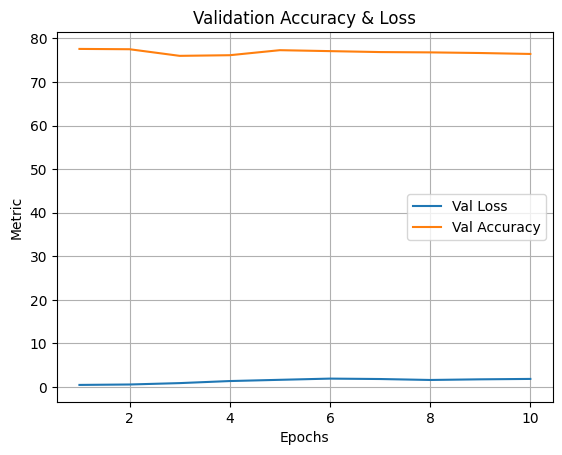

In [12]:
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp.to(device)

best_val_acc = 0
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(10):
    mlp.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = mlp(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    mlp.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = mlp(xb)
            val_loss += criterion(out, yb).item()
            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        torch.save(mlp.state_dict(), "checkpoint.pt")
        best_val_acc = val_acc

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Val Acc={val_acc:.2f}%")

# Plot
plt.plot(range(1, 11), val_losses, label='Val Loss')
plt.plot(range(1, 11), val_accuracies, label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Metric")
plt.legend()
plt.title("Validation Accuracy & Loss")
plt.grid(True)
plt.show()


In [13]:
import torch.quantization

quantized_model = torch.quantization.quantize_dynamic(
    mlp.cpu(), {nn.Linear}, dtype=torch.qint8  # Use qint8, true INT4 not supported in PyTorch directly
)
torch.save(quantized_model.state_dict(), "quantized_dynamic.pt")


In [14]:
fp16_model = MLP(input_size=input_size)  # Reload model fresh
fp16_model.load_state_dict(torch.load("checkpoint.pt"))
fp16_model = fp16_model.half()
torch.save(fp16_model.state_dict(), "half_precision.pt")


In [15]:
import os, time

def evaluate_model(model, loader, use_half=False):
    model.eval().cpu()
    if use_half:
        model = model.half()

    correct, total = 0, 0
    start = time.time()
    with torch.no_grad():
        for xb, yb in loader:
            if use_half:
                xb = xb.half()
            out = model(xb)
            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    end = time.time()
    acc = 100 * correct / total
    avg_time = (end - start) * 1000 / total  # ms/sample
    return acc, avg_time

# Reload original model for evaluation
original_model = MLP(input_size=input_size)
original_model.load_state_dict(torch.load("checkpoint.pt"))

# Evaluate
original_acc, original_time = evaluate_model(original_model, DataLoader(val_dataset))
quant_acc, quant_time = evaluate_model(quantized_model, DataLoader(val_dataset))
half_acc, half_time = evaluate_model(fp16_model, DataLoader(val_dataset), use_half=True)

# Storage size
def get_size(path):
    return os.path.getsize(path) / 1e6  # in MB

torch.save(original_model.state_dict(), "original.pt")
print(f"{'Model':<12} | {'Accuracy (%)':<12} | {'Size (MB)':<10} | {'Infer Time (ms)':<16}")
print(f"{'-'*55}")
print(f"{'Original':<12} | {original_acc:<12.2f} | {get_size('original.pt'):<10.2f} | {original_time:<16.2f}")
print(f"{'Dynamic':<12} | {quant_acc:<12.2f} | {get_size('quantized_dynamic.pt'):<10.2f} | {quant_time:<16.2f}")
print(f"{'Half':<12} | {half_acc:<12.2f} | {get_size('half_precision.pt'):<10.2f} | {half_time:<16.2f}")


Model        | Accuracy (%) | Size (MB)  | Infer Time (ms) 
-------------------------------------------------------
Original     | 77.60        | 21.18      | 1.59            
Dynamic      | 76.45        | 5.30       | 0.99            
Half         | 77.60        | 10.59      | 1.51            
